In [1]:
from smartbuilder import graphlib
g = graphlib.Graph()

In [2]:
g.add_edge('index.rst', 'index.html')
g.add_edge('tutorial.rst', 'tutorial.html')
g.add_edge('api.rst', 'api.html')

consequences_of = {}
consequences_of['index.rst'].add('index.html')

KeyError: 'index.rst'

In [ ]:
from collections import defaultdict
consequences_of = defaultdict(set)
consequences_of['api.rst']

In [ ]:
consequences_of['index.rst'].add('index.html')
'index.html' in consequences_of['index.rst']

In [3]:
from pprint import pprint
pprint(g.edges())

[('api.rst', 'api.html'),
 ('index.rst', 'index.html'),
 ('tutorial.rst', 'tutorial.html')]


In [4]:
g.immediate_consequences_of('api.rst')

['api.html']

In [5]:
g.immediate_consequences_of('index.html')

[]

In [6]:
from smartbuilder.rendering import as_graphviz
open('fig1.dot', 'w').write(as_graphviz(g)) and None

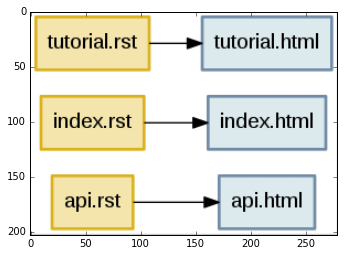

In [7]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('fig1.png', 'r')
imshow(np.asarray(pil_im))


In [8]:
g.add_edge('api.rst', 'api-title')
g.add_edge('api-title', 'index.html')
g.add_edge('tutorial.rst', 'tutorial-title')
g.add_edge('tutorial-title', 'index.html')

In [9]:
open('fig2.dot', 'w').write(as_graphviz(g)) and None

In [10]:
!dot -Tpng fig2.dot > fig2.png

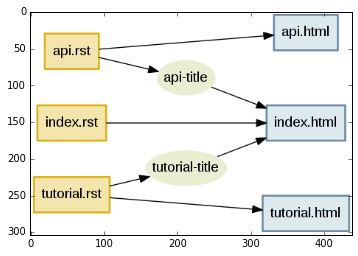

In [11]:
pil_im = Image.open('fig2.png', 'r')
imshow(np.asarray(pil_im))

# 项目构建图
下面我们将文档的构建任务使用图来表示,由于文档之间有依赖关系,因此在构建文档的过程中, 构建任务之间也有类似的依赖关系,我们将这些构建任务(可以看做是一个函数)依赖关系(函数调用关系)构造成一个有向无环图! 

任务 task 是图中的一个节点, task 之间的依赖关系是图中的有向边!我们如何才能发现 task 之间的调用关系? 手动分析显然是一种方法,但显然不是自动化的! 一个简单的过程是 render --> parse --> read, 即 render() 会调用 parse() 函数, parse() 函数又会调用 read() 函数. 函数调用的过程中会有压栈的操作, 函数调用完成之后又会返回, 我们能不能监控这个过程呢? 

如果使用的是 C/C++, 你显然很难监控. 因为C/C++ 程序最终被编译成二进制机器指令后, 直接在CPU 上执行, 并由操作系统调度 C/C++ 程序的宿主进程. 你要想完成监控,除非你找操作系统帮忙! 那么 Java 呢? Java 就可以监控 Java 字节码 的压栈出栈操作, 因为 Java 字节码 运行在 JVM 虚拟机上啊! 也就是说, Java 里面的非本地方法调用, 都是JVM 解释执行的, JVM 模拟压栈出栈操作, 当然就可以跟踪了! 也就是说, JVM 的代码是二进制机器码, 直接在CPU上执行, CPU是认识的, 但是 Java 字节码 当然是在 JVM虚拟机进程中执行, 他是 JVM 操控的! 

对于 Python, 和 Java 是类似的, Python 脚本是由 Python 解释器执行的, Python 解释器进程 会把 Python 脚本当参数进行解释执行, 函数的压栈和出栈当然解释器一目了然, 但是 Python 更厉害的地方在于, 函数调用的跟踪不需要和 解释器打交道, Python 语言本身提供了这种机制! 即装饰器! 跟踪函数调用关系, 其实本质上就是想在函数进栈之前,出栈之后做点小动作, 比如记录跟踪等, 这个需求, 就是在函数调用之前做点小动作, 函数调用之后再做点小动作, 这不就是装饰器的典型功能么! 如果你对 函数式编程 和 Python 装饰器不了解, 可以查阅我的另外两篇博客!

In [12]:
index = """
Table of Contents
-----------------
* `tutorial.txt`
* `api.txt`
"""

tutorial = """
Beginners Tutorial
------------------
Welcome to the tutorial!
We hope you enjoy it.
"""

api = """
API Reference
-------------
You might want to read
the `tutorial.txt` first.
"""

filesystem = {'index.txt': index, 'tutorial.txt': tutorial, 'api.txt': api}

In [13]:
from smartbuilder.projectlib import Project, Task
project = Project()
task = project.task

以上内容模仿了一个文件读取过程,然后,我们使用 projectlib 中的 task 装饰器来装饰任务, 这样我们就能够获得任务直接的依赖关系(函数调用关系), 这里可以看到装饰器的强大之处, 可以跟踪函数调用过程,即压栈过程!

In [15]:
@task
def read(filename):
    return filesystem[filename]

@task
def parse(filename):
    lines = read(filename).strip().splitlines()
    title = lines[0]
    body = '\n'.join(lines[2:])
    return title, body

@task
def title_of(filename):
    title, body = parse(filename)
    return title

装饰器代码: 我们在每个任务函数执行之前之后, 做点小动作即可! 为了跟踪函数调用的压栈出栈操作, 我们也申请了一个栈 task_stack, 每次任务调用之前做点小动作后就将其压栈, 调用完成后就出栈并做点小动作! 这就是我们原来在C, Java 中实现的经典递归套路, (比如打印二叉树根到叶节点的所有路径等, 若使用先序遍历,就会将遇到的节点先入栈保存,然后递归执行下一次任务, 每次到底的时候, 就打印一条路径, 然后出栈叶节点)

```python
def task(function):
    @wraps(function)
    def wrapper(*args):
        task = Task(wrapper, args)
        if self.task_stack:
            self._graph.add_edge(task, self.task_stack[-1])
        self._graph.clear_inputs_of(task)
        self._task_stack.append(task)
        try:
            value = function(*args)
        finally:
            self._task_stack.pop()

        return value
    return wrapper
```
由于执行当前任务时,调用者肯定在栈顶, 当前被调用的任务就就是该任务本身, 这样就可以很容易拿到调用关系图中的一条边! 即 (task, task_stack[-1]), 输入是被调用者,即被依赖对象, 输出是调用者! 清空 task 的先前的所有输入!

In [16]:
import re
LINK = '<a href="{}">{}</a>'
PAGE = '<h1>{}</h1>\n<p>\n{}\n<p>'

def make_link(match):
    filename = match.group(1)
    return LINK.format(filename, title_of(filename))

@task
def render(filename):
    title, body = parse(filename)
    body = re.sub(r'`([^`]+)`', make_link, body)
    return PAGE.format(title, body)

In [17]:
print(render('tutorial.txt'))

<h1>Beginners Tutorial</h1>
<p>
Welcome to the tutorial!
We hope you enjoy it.
<p>


# graphviz
可以使用 graphviz 可视化你的图! 只要将图中的边,节点按照固定格式写入 .dot 文件中即可! 然后运行 `dot -Tpng fig.dot > fig.png` 即可!

In [35]:
open('fig4.3.dot', 'w').write(as_graphviz(project._graph)) and None
!dot -Tpng fig4.3.dot > fig4.3.png

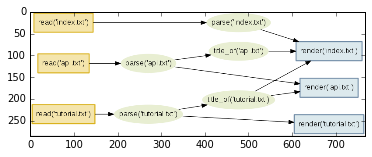

In [36]:
pil_im = Image.open('fig4.3.png', 'r')
imshow(np.asarray(pil_im))

Task 是一个 类, 继承了 namedtuple, 并重写了他的 \_\_repr\_\_() 方法!
```python
class Task(namedtuple('Task', ('task_function', 'args'))):
    """
    把一个 函数调用 转变为一个 二元 tuple 任务

    给定 任务函数 和 一个参数列表, 返回一个 二元tuple.
    """
    __slots__ = ()

    def __new__(cls, task_function, args):
        try:
            hash(args)
        except TypeError as e:
            raise ValueError('arguments to project tasks must be immutable and hashable, not the {}'.format(e))
        
        return super(Task, cls).__new__(cls, task_function, args)
    
    def __repr__(self):
        "语法糖, 任务的源代码表示"

        return '{}({})'.format(self.task_function.__name__,
                              ', '.join(repr(arg) for arg in self.args))
```

In [37]:
task = Task(read, ('tutorial.txt',))
print task

read('tutorial.txt')


In [38]:
project._graph.immediate_consequences_of(task)

[parse('tutorial.txt')]

In [39]:
for filename in 'index.txt', 'tutorial.txt', 'api.txt':
    print(render(filename))
    print('=' * 30)

<h1>Table of Contents</h1>
<p>
* <a href="tutorial.txt">The Coder Tutorial</a>
* <a href="api.txt">API Reference</a>
<p>
<h1>The Coder Tutorial</h1>
<p>
Welcome to the coder tutorial!
It should be read top to bottom.
<p>
<h1>API Reference</h1>
<p>
You might want to read
the <a href="tutorial.txt">The Coder Tutorial</a> first.
<p>


In [24]:
open('fig4.4.dot', 'w').write(as_graphviz(project._graph)) and None

In [25]:
!dot -Tpng fig4.4.dot > fig4.4.png

(768, 285)


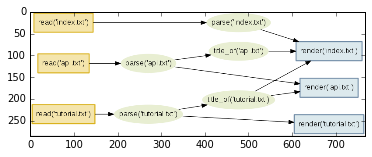

In [26]:
pil_im = Image.open('fig4.4.png', 'r')
print pil_im.size
imshow(np.asarray(pil_im))

# 缓存cache
为了防止过多的重构任务, 对于结果没有变的任务, 其后续任务就不必再执行了, 因此我们加入 cache 机制, 并检查 当前任务和 cache 结果是否一致, 一致则不再需要执行后续任务了! 为了方便, 定义一个缓存失效的标准! \_unavailable 是一个单例模式, 所有的失效都返回她;

```python
def _get_from_cache(self, task):
    """返回给定 `task` 的输出.

    如果无法查到一个现有的有效的 任务cache, 就返回 单例 _unavailable.
    """
    if not self._cache_on:
        return _unavailable
    if task in self._todo:
        return _unavailable
    return self._cache.get(task,_unavailable)
```

当每次执行任务返回后,也需要将任务的返回值放入缓存之中!并且此时可以比较和上一次任务是否有变化, 有变化, 就可以更新缓存, 并需要重新执行该任务影响到的后续任务!因此还引入一个 todo list, 存放将要执行的任务!
```python
def set(self, task, return_value):
    """添加 `task` 的运行结果值 `return_value` 到 输出值缓存中.

    这里我们有机会比较新值和上一次任务返回结果的旧值, 
    从而决定那些使用 `task` 作为输入的任务集合是否需要被
    加入到 todo 列表中重新进行计算
    """
    self._todo.discard(task)
    if (task not in self._cache) or (self._cache[task] != return_value):
        self._cache[task] = return_value
        self._todo.update(self._graph.immediate_consequences_of(task))
```

加入缓存机制后, 任务调用过程中, 有些任务可以不必再调用了, 我们已经保存了某些

In [27]:
task = Task(read, ('api.txt',))
project._graph.immediate_consequences_of(task)

[parse('api.txt')]

In [28]:
_pprint = pprint
pprint = lambda x: _pprint(x, width=40)
pprint(project._graph.recursive_consequences_of([task]))

[parse('api.txt'),
 render('api.txt'),
 title_of('api.txt'),
 render('index.txt')]


In [29]:
filesystem['tutorial.txt'] = """
The Coder Tutorial
------------------
This is a new and improved
introductory paragraph.
"""

In [30]:
with project.cache_off():
    text = read('tutorial.txt')

In [31]:
project.start_tracing()
project.rebuild()
print(project.stop_tracing())

calling parse('tutorial.txt')
calling render('tutorial.txt')
calling title_of('tutorial.txt')
calling render('api.txt')
calling render('index.txt')


以下当 task title_of() 的内容和缓存中的内容一样时, title_of() 的consequences 将不会受到影响,因此就不用放入 todo了, 不再执行!

In [32]:
filesystem['tutorial.txt'] = """
The Coder Tutorial
------------------
Welcome to the coder tutorial!
It should be read top to bottom.
"""
with project.cache_off():
    text = read('tutorial.txt')

In [33]:
project.start_tracing()
project.rebuild()
print(project.stop_tracing())

calling parse('tutorial.txt')
calling render('tutorial.txt')
calling title_of('tutorial.txt')
